In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import seed
seed(1)

SEED = 123 
DATA_SPLIT_PCT = 0.2

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.rcParams.update({'font.size': 22})

2024-06-24 10:13:40.804683: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 10:13:40.947128: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 10:13:41.528952: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 10:13:42.991363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#TOOKED FROM THE BOOK
def temporalize(X, y, lookback):
    '''
    Inputs
    X         A 2D numpy array ordered by time of shape: (n_observations x n_features)
    y         A 1D numpy array with indexes aligned with X, i.e. y[i] should correspond to X[i]. Shape: n_observations.
    lookback  The window size to look back in the past records. Shape: a scalar.

    Output
    output_X  A 3D numpy array of shape: ((n_observations-lookback-1) x lookback x n_features)
    output_y  A 1D array of shape: (n_observations-lookback-1), aligned with X.
    '''
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather the past records upto the lookback period
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

def flatten(X):
    '''
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty(
        (X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return flattened_X

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize

    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])

    return X

# Data preparation

Here we do the same as we do in the LSTM notebook

In [3]:
df = pd.read_csv("reanalysis.csv")

TARGET = "sfcWind"

df=df.rename(columns={TARGET:'y'})

#Delete all the columns related to a daily scale
for col in df.columns:
    if "_" not in col and col != "y" and col != "time":
        df.drop(col, axis=1, inplace=True)

df["month"] = pd.to_datetime(df["time"]).dt.month
df["hour"] = pd.to_datetime(df["time"]).dt.hour

df.head()

# For the target variable get the daily previous value and the daily next value
df["date"] = df["time"].apply(lambda x: x.split(" ")[0])
df_2 = df.copy()
df_2 = df_2[["date", TARGET + "_daily"]].groupby("date").mean()
df_2[TARGET+"_prev_daily"] = df_2[TARGET + "_daily"].shift(1)
df_2[TARGET+"_next_daily"] = df_2[TARGET + "_daily"].shift(-1)
df_2.drop(TARGET + "_daily", axis=1, inplace=True)
df_2.dropna(inplace=True)
df = df.merge(df_2, on="date", how="inner").drop("date", axis=1)

# Convert Categorical column to hot dummy columns
hotencoding1 = pd.get_dummies(df['month'])
hotencoding1 = hotencoding1.add_prefix('month')
hotencoding2 = pd.get_dummies(df['hour'])
hotencoding2 = hotencoding2.add_prefix('hour')

df=df.drop(['month', 'hour'], axis=1)

df=pd.concat([df, hotencoding1, hotencoding2], axis=1)

#Filter the rows with time less than 2015-01-01
df_train = df[df['time'] < '2013-12-31 23:59:00']
df_test = df[df['time'] >= '2013-12-31 23:59:00']

df_train = df_train.set_index('time')
df_test = df_test.set_index('time')

input_X_train = df_train.loc[:, df_train.columns != 'y'].values  # converts df to numpy array
input_X_test = df_test.loc[:, df_test.columns != 'y'].values  
input_y_train = df_train['y'].values
input_y_test = df_test['y'].values

n_features = input_X_train.shape[1]  # number of features


# Model

In [4]:
lookback = 10
X_train, y_train = temporalize(X=input_X_train, 
                      y=input_y_train, 
                      lookback=lookback)
X_test, y_test = temporalize(X=input_X_test, 
                      y=input_y_test, 
                      lookback=lookback)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=DATA_SPLIT_PCT,
    random_state=SEED)

TIMESTEPS = X_train.shape[1]  # equal to the lookback
N_FEATURES = X_train.shape[2]  # the number of features
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train))
X_train_scaled = scale(X_train, scaler).astype(np.float32)
X_valid_scaled = scale(X_valid, scaler).astype(np.float32)
X_test_scaled =  scale(X_test, scaler).astype(np.float32)

In [5]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, 
                       N_FEATURES), 
                name='input'))
model.add(Conv1D(filters=16, 
                 kernel_size=4,
                 activation='relu', 
                 padding='valid'))
model.add(MaxPool1D(pool_size=4, 
                    padding='valid'))
model.add(Flatten())
model.add(Dense(units=16, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='linear', 
                name='output'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 16)          │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,121 (12.19 KB)

 Trainable params: 3,121 (12.19 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=[
                  tf.keras.metrics.RootMeanSquaredError()
              ])
history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=1).history

Epoch 1/150


2024-06-24 10:14:10.306363: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172627840 exceeds 10% of free system memory.


751/767 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4491 - root_mean_squared_error: 1.4268

2024-06-24 10:14:13.351401: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43156960 exceeds 10% of free system memory.


767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.4145 - root_mean_squared_error: 1.4161 - val_loss: 0.3718 - val_root_mean_squared_error: 0.6098
Epoch 2/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3720 - root_mean_squared_error: 0.6099 - val_loss: 0.3599 - val_root_mean_squared_error: 0.5999
Epoch 3/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3602 - root_mean_squared_error: 0.6001 - val_loss: 0.3545 - val_root_mean_squared_error: 0.5954
Epoch 4/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3565 - root_mean_squared_error: 0.5971 - val_loss: 0.3520 - val_root_mean_squared_error: 0.5933
Epoch 5/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3493 - root_mean_squared_error: 0.5910 - val_loss: 0.3448 - val_root_mean_squared_error: 0.5872
Epoch 6/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3462 - root_mean_squared_error: 0.5883 - val_loss: 0.3435 - val_root_mean_squared_error: 0.5861
Epoch 7/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - los

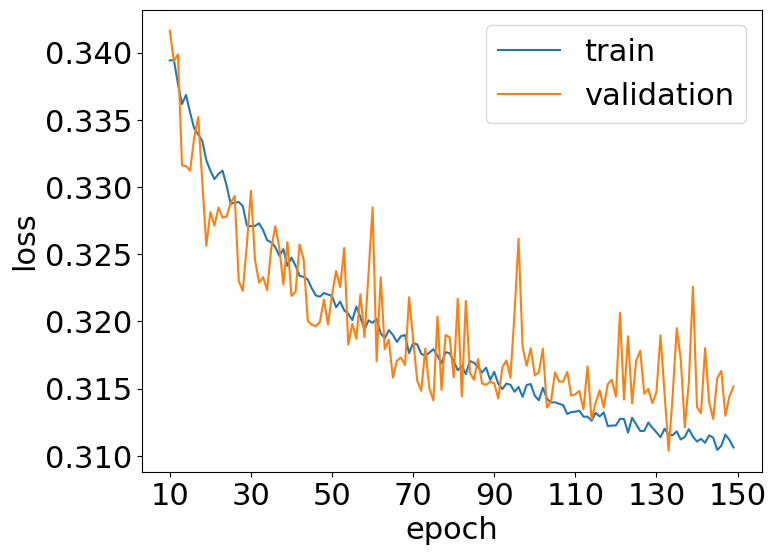

In [10]:
#plot the training and validation loss after the first 10 epochs
plt.plot(range(10,150),history['loss'][10:])
plt.plot(range(10,150),history['val_loss'][10:])  
plt.legend(['train', 'validation'])
plt.xticks(range(10,151,20))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

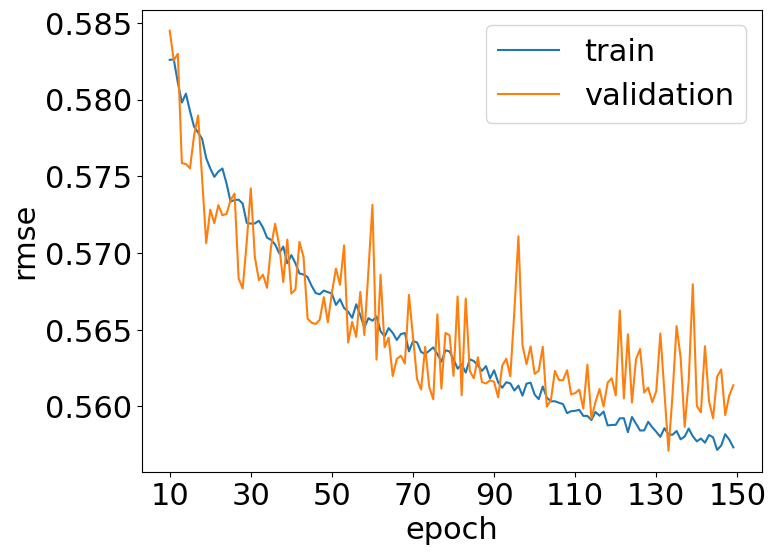

In [11]:
#plot the training and validation rmse after the first 10 epochs,
plt.plot(range(10,150),history['root_mean_squared_error'][10:])
plt.plot(range(10,150),history['val_root_mean_squared_error'][10:])
plt.legend(['train', 'validation'])
plt.xticks(range(10,151,20))
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.show()

In [12]:
p = model.predict(np.asarray(X_test_scaled).astype('float32'))
res = pd.DataFrame(p)
filename = "cnn_output_" + TARGET + ".csv"
res.to_csv(filename, index=False)

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
